In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [14,4]

from gwpy.timeseries import TimeSeries

import bilby
from bilby.core.prior import Uniform, PowerLaw
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

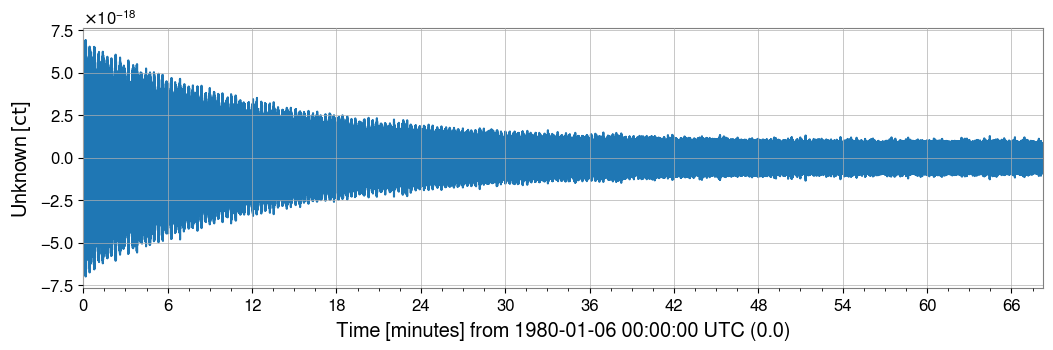

In [2]:
H1strain = TimeSeries.read("challenge3_2048hz.gwf", "H1:CHALLENGE3")
L1strain = TimeSeries.read("challenge3_2048hz.gwf", "L1:CHALLENGE3")

H1strain.plot()
plt.show()

In [3]:
# trigger times
trg_time, trg_nsnr, trg_mass = np.genfromtxt("triggers_PE.dat", delimiter=',', comments='#', unpack=True)

# analysis time window
post_trigger_duration = 2
duration = 4
analysis_start = trg_time + post_trigger_duration - duration
psd_duration = duration * 32
psd_start_time = analysis_start - psd_duration

In [4]:
# #! trigger times, since both H1, L1 are roughly triggered at the same time, and we are taking window of 4 secs, thus no issues
# trg_time, trg_nsnr, trg_mass = {}, {}, {}
# trg_time['H1'], trg_nsnr['H1'], trg_mass['H1'] = np.genfromtxt("triggers_PE_H1.dat", delimiter=',', comments='#', unpack=True)
# trg_time['L1'], trg_nsnr['L1'], trg_mass['L1'] = np.genfromtxt("triggers_PE_L1.dat", delimiter=',', comments='#', unpack=True)

# # analysis time window
# analysis_start, psd_start_time = {}, {}
# post_trigger_duration = 2
# duration = 4
# analysis_start['H1'] = trg_time['H1'] + post_trigger_duration - duration
# analysis_start['L1'] = trg_time['L1'] + post_trigger_duration - duration
# psd_duration = duration * 32
# psd_start_time['H1'] = analysis_start['H1'] - psd_duration
# psd_start_time['L1'] = analysis_start['L1'] - psd_duration

In [5]:
i = 0
# index of the peak to be done Parameter Estimation of

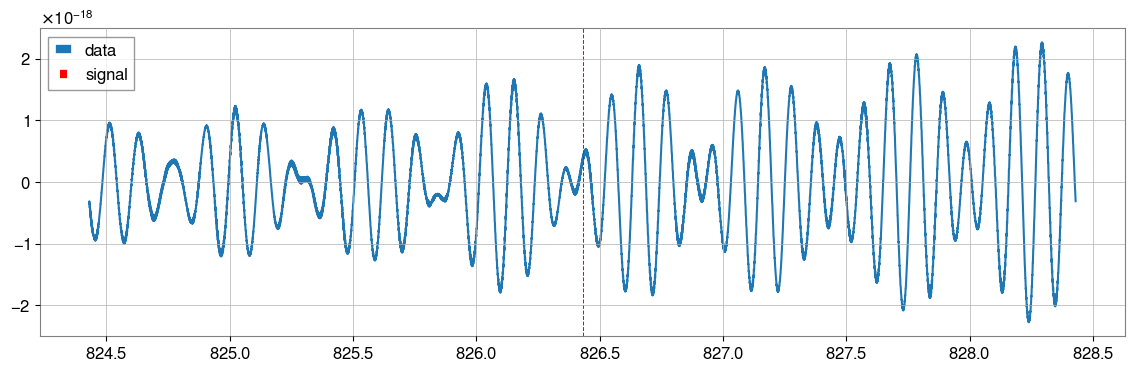

In [6]:
idx1 = int(H1strain.sample_rate.value * analysis_start[i])
idx2 = int(H1strain.sample_rate.value * (analysis_start[i] + duration))

plt.plot(H1strain.times[idx1:idx2], H1strain[idx1:idx2], label='data')
plt.axvline(trg_time[i], color='red', linestyle='--', linewidth=0.75, label='signal')
plt.legend()

In [7]:
# Interferometers
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")
H1.set_strain_data_from_gwpy_timeseries(H1strain[idx1:idx2])
L1.set_strain_data_from_gwpy_timeseries(L1strain[idx1:idx2])


00:24 bilby INFO    : Generating frequency domain strain from given time domain strain.
00:24 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


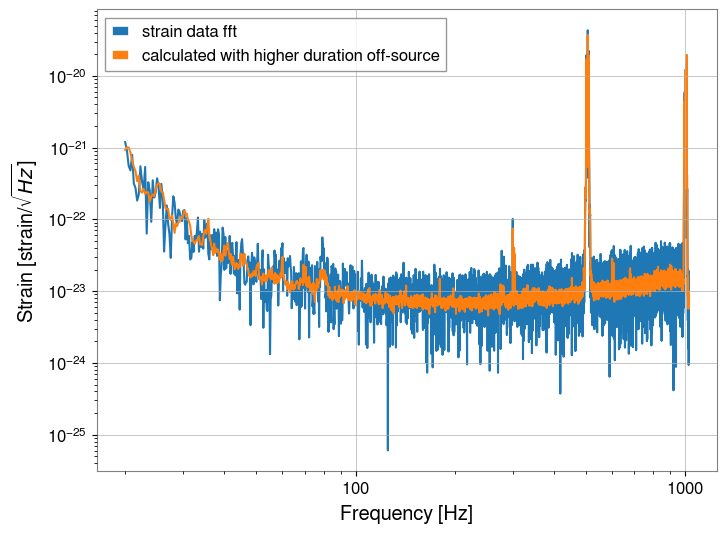

In [8]:
psd_idx1 = int(H1strain.sample_rate.value * psd_start_time[i])
psd_idx2 = int(H1strain.sample_rate.value * (psd_start_time[i] + psd_duration))

H1_psd = H1strain[psd_idx1:psd_idx2]
L1_psd = L1strain[psd_idx1:psd_idx2]

psd_alpha = 2 * H1.strain_data.roll_off / duration
H1_psd = H1_psd.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
L1_psd = L1_psd.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")

H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=L1_psd.frequencies.value, psd_array=L1_psd.value)

H1.maximum_frequency = 1024
L1.maximum_frequency = 1024
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
plt.subplots(figsize=[8,6])
plt.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]), label='strain data fft')
plt.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs], label='calculated with higher duration off-source')
plt.legend()
plt.xlabel("Frequency [Hz]")
plt.ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

## Parameter Estimation part

$$\mathcal{M} = \frac{(m_1m_2)^{3/5}}{(m_1+m_2)^{1/5}}$$
$$q = \frac{m_2}{m_1} < 1$$

In [9]:
def chirp(m1, m2):
    return ((m1*m2)**(3/5)) / ((m1+m2)**(1/5))
m = np.linspace(10, 50, 5)
chirp(m, m)

array([ 8.70550563, 17.41101127, 26.1165169 , 34.82202253,
       43.52752816])

In [10]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=30.0,maximum=32.5)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.5, maximum=1)
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=trg_time[0]-0.1, maximum=trg_time[0]+0.1)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232                     # some random values, won't matter, we are after mass determination
prior['ra'] =  2.19432                      # some random values, won't matter, we are after mass determination
prior['theta_jn'] =  1.89694                # some random values, won't matter, we are after mass determination
prior['psi'] =  0.532268                    # some random values, won't matter, we are after mass determination
prior['luminosity_distance'] = PowerLaw(alpha=2, name='luminosity_distance', minimum=50, maximum=2000, unit='Mpc', latex_label='$d_L$')


In [11]:
# First, put our "data" created above into a list of interferometers (the order is arbitrary)
interferometers = [H1, L1]

# Next create a dictionary of arguments which we pass into the LALSimulation waveform - we specify the waveform approximant here
waveform_arguments = dict(
    waveform_approximant='IMRPhenomD', reference_frequency=100., catch_waveform_errors=True)

# Next, create a waveform_generator object. This wraps up some of the jobs of converting between parameters etc
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

# Finally, create our likelihood, passing in what is needed to get going
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=True)

00:24 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
00:24 bilby INFO    : Loaded distance marginalisation lookup table from .distance_marginalization_lookup.npz.


In [12]:
result_short = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short', label="CHALLENGE4PE1",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    nlive=250, dlogz=1.,  # <- Arguments are used to make things fast - not recommended for general use
    clean=True,
)

# result_short = bilby.core.result.read_in_result("short/CHALLENGE4PE1_result.json")


00:24 bilby INFO    : Running for label 'CHALLENGE4PE1', output will be saved to 'short'
00:24 bilby INFO    : Using lal version 7.2.4
00:24 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.2.4;Id: e5e51f77cbaf264a20a620b4acefbe7ac38c84c6;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
00:24 bilby INFO    : Using lalsimulation version 4.0.2
00:24 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v4.0.2;Id: 233cc3963d87688c272b7affe7dd0b962e4c11a0;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
00:24 bilby INFO    : Analysis priors:
00:24 bilby INFO    : chirp_mass=Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
00:24 bilby INFO    : mass_ratio=Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
00:24 bilby INFO    : time_jitter=Uniform(m

1it [00:00, ?it/s]

00:29 bilby INFO    : Written checkpoint file short/CHALLENGE4PE1_resume.pickle
00:29 bilby INFO    : Rejection sampling nested samples to obtain 264 posterior samples
00:29 bilby INFO    : Sampling time: 0:04:39.328793


00:29 bilby INFO    : Computing per-detector log likelihoods.


  0%|          | 0/264 [00:00<?, ?it/s]

00:29 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/264 [00:00<?, ?it/s]

00:29 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/264 [00:00<?, ?it/s]

00:29 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/264 [00:00<?, ?it/s]

00:29 bilby INFO    : Summary of results:
nsamples: 264
ln_noise_evidence: -8450.374
ln_evidence: -8430.604 +/-  0.199
ln_bayes_factor: 19.770 +/-  0.199



In [13]:
result_short.posterior

,chirp_mass,mass_ratio,time_jitter,phase,geocent_time,a_1,a_2,tilt_1,tilt_2,phi_12,...,chi_2_in_plane,chi_p,cos_tilt_1,cos_tilt_2,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source
0,31.955179,0.512204,-0.000479,2.233287,826.408864,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.141840,606.606413,45.414281,23.261379,27.985700,68.675660
1,30.724690,0.504308,0.000283,2.359307,826.409326,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.148966,635.949082,43.755234,22.066125,26.741162,65.821359
2,31.417016,0.578085,0.000158,5.533203,826.409234,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.134015,574.262229,42.167431,24.376375,27.704240,66.543806
3,32.432251,0.758600,0.000097,5.726681,826.409951,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.218093,914.839708,35.182163,26.689174,26.625434,61.871337
4,32.457151,0.968080,0.000016,2.763935,826.410500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.253383,1053.204852,30.233501,29.268436,25.895634,59.501937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,30.038674,0.991108,0.000484,6.030049,826.410796,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.158353,674.428223,29.921706,29.655646,25.932238,59.577352
274,30.016496,0.999671,0.000447,3.037597,826.411036,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.141145,603.742175,30.220139,30.210200,26.303832,60.430339
275,30.009691,0.938847,-0.000446,6.112712,826.411169,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.236201,986.175013,28.782221,27.022112,24.275745,55.804333
276,30.006010,0.969449,0.000440,2.838489,826.411024,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.142634,609.883458,30.637625,29.701604,26.260383,60.339229


In [14]:
result_short.posterior.columns

Index(['chirp_mass', 'mass_ratio', 'time_jitter', 'phase', 'geocent_time',
       'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl', 'dec', 'ra',
       'theta_jn', 'psi', 'luminosity_distance', 'log_likelihood', 'log_prior',
       'reference_frequency', 'waveform_approximant', 'minimum_frequency',
       'total_mass', 'mass_1', 'mass_2', 'H1_log_likelihood',
       'L1_log_likelihood', 'H1_matched_filter_snr', 'H1_optimal_snr',
       'L1_matched_filter_snr', 'L1_optimal_snr', 'symmetric_mass_ratio',
       'iota', 'spin_1x', 'spin_1y', 'spin_1z', 'spin_2x', 'spin_2y',
       'spin_2z', 'phi_1', 'phi_2', 'chi_eff', 'chi_1_in_plane',
       'chi_2_in_plane', 'chi_p', 'cos_tilt_1', 'cos_tilt_2', 'redshift',
       'comoving_distance', 'mass_1_source', 'mass_2_source',
       'chirp_mass_source', 'total_mass_source'],
      dtype='object')

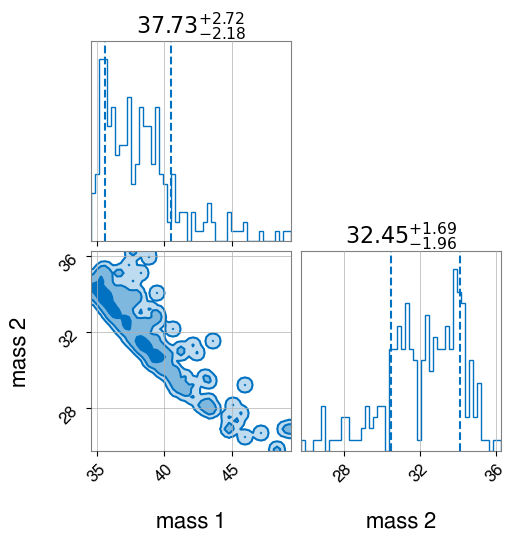

In [31]:
result_short.plot_corner(parameters=["mass_1", "mass_2"], prior=True)

In [32]:
mass_summary = bilby.core.utils.SamplesSummary(samples=result_short.posterior['mass_1'], average='median')
print('mass_1 = {:.4f} Msun'.format(mass_summary.median))
print('The 90% confidence interval : {:.4f} - {:.4f} Msun'.format(mass_summary.lower_absolute_credible_interval,
                                                                        mass_summary.upper_absolute_credible_interval))

mass_summary = bilby.core.utils.SamplesSummary(samples=result_short.posterior['mass_2'], average='median')
print('mass_2 = {:.4f} Msun'.format(mass_summary.median))
print('The 90% confidence interval : {:.4f} - {:.4f} Msun'.format(mass_summary.lower_absolute_credible_interval,
                                                                        mass_summary.upper_absolute_credible_interval))

mass_1 = 37.7339 Msun
The 90% confidence interval : 35.1520 - 43.5636 Msun
mass_2 = 32.4516 Msun
The 90% confidence interval : 27.9720 - 34.8981 Msun


> Found mass for 1st peak  
[Prior in mass 30.0 to 32.5]  
[mass_ratio = 1]  
mass_1 = 34.8033 Msun  
The 90% confidence interval : 34.4845 - 36.2505 Msun

>[mass_ratio 0.5 to 1]  
> - Trial 1  
mass_1 = 37.2675 Msun  
The 90% confidence interval : 34.9331 - 43.7811 Msun  
mass_2 = 32.7298 Msun  
The 90% confidence interval : 28.1236 - 34.9822 Msun  
> - Trial 2  
mass_1 = 37.7339 Msun  
The 90% confidence interval : 35.1520 - 43.5636 Msun  
mass_2 = 32.4516 Msun  
The 90% confidence interval : 27.9720 - 34.8981 Msun  




>[mass 8 to 43.5]  
> - Trial 1  
mass_1 = 33.5956 Msun  
The 90% confidence interval : 29.5930 - 39.2061 Msun  
mass_2 = 25.5789 Msun  
The 90% confidence interval : 20.8518 - 29.4000 Msun  
> - Trial 2  
mass_1 = 32.6774 Msun  
The 90% confidence interval : 29.1760 - 38.7740 Msun  
mass_2 = 26.0387 Msun  
The 90% confidence interval : 20.9763 - 29.6423 Msun  
> - Trial 3  
mass_1 = 32.8025 Msun  
The 90% confidence interval : 29.3634 - 39.7380 Msun  
mass_2 = 26.2134 Msun  
The 90% confidence interval : 21.0738 - 29.6711 Msun

In [3]:
33.05-2.37, 33.05+3.55

(30.679999999999996, 36.599999999999994)

In [4]:
25.83-3.20, 25.83+3.05

(22.63, 28.88)

In [8]:
trg_mass[0]

30.0